# Classification de textes Francais par entreprise

# Fetching labelised corpus

In [2]:
# imports
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
from copy import deepcopy
import ast
from scipy import stats
import re
import matplotlib.pyplot as plt

In [83]:
# fetching data
PATH = "./data/ArticleCompany_2020-11-17/"
coprus = "corpus_check_long_SIREN_UPDATED2"
names = "siren_name_map_clean"

with open(PATH + names +".json") as json_file: 
    dict_names = json.load(json_file) 

with open(PATH + coprus +".json") as json_file: 
    corpus_list = json.load(json_file) 

In [84]:
# Convert labels from string to list
print ("The siren list is:",type(corpus_list[0]["siren"]))
for document in corpus_list:
    document["siren"] = ast.literal_eval(document["siren"]) # convert list in string format to list
    for i in range(len(document["siren"])): # Convert each int siren to string 
        document["siren"][i] = str(document["siren"][i])
print ("NOW the type of the siren list is:",type(corpus_list[0]["siren"]))

The siren list is: <class 'str'>
NOW the type of the siren list is: <class 'list'>


# Cleaning corpus data

In [85]:
# Removing empty articles 
corpus_list_inter = list()
for i in range(len(corpus_list)):
    if len(corpus_list[i]["corpus"])<100: # small enough
        text = corpus_list[i]["corpus"]
        text = re.sub("^(\s+)", '', text)
        if (len(text)>0):
            corpus_list_inter.append(corpus_list[i])
        else:
            print ("Index of removed article:",i,corpus_list[i]["corpus"])
    else:
        corpus_list_inter.append(corpus_list[i])
corpus_list = corpus_list_inter

Index of removed article: 29805   
Index of removed article: 30158     


# Description of corpus

In [86]:
sirens = list()
for document in corpus_list:
    for siren in document["siren"]:
        sirens.append(siren)

corpus_sirens = set(sirens)
siren_only_in_corpus = list()
for siren in corpus_sirens:
    if siren not in dict_names.keys():
        siren_only_in_corpus.append(siren)


print("There are",len(corpus_sirens),"distinct labeled companies in the corpus")
print ("There are",len(siren_only_in_corpus),"sirens in the corpus labels and not in the company name list")
print ("There are", len(corpus_list), "articles in the corpus")
print ("There are", len(dict_names), "companies in the list")

There are 28690 distinct labeled companies in the corpus
There are 1623 sirens in the corpus labels and not in the company name list
There are 57538 articles in the corpus
There are 30178 companies in the list


# Tokenizing Articles

## Method 1: Tokenising corpus removing stopwords 3:30 min

In [87]:
#imports
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
stop_words = stopwords.words('french')
print ("Number of stop words",len(stop_words ))
print ("Ex:",stop_words[:5])

Number of stop words 157
Ex: ['au', 'aux', 'avec', 'ce', 'ces']


### Cleaning the plain text

In [88]:
# Tokenize corpus inplace
def tokenize_corpus(corpus):   
    for document in tqdm(corpus):
        plain_text = document["corpus"]
        plain_text = plain_text.lower()
        plain_text= re.sub(r'\s+', ' ', plain_text)
        #plain_text = re.sub("[^a-z0-9]", ' ', plain_text)
        plain_text = re.sub("[^a-z]", ' ', plain_text)
        plain_text = re.sub(r'\s+', ' ', plain_text)
        #remove one letter words?
        #remove numbers?
        pt_words = word_tokenize(plain_text)
        cleaned_words =list()
        for word in pt_words:
            if len(word)>1:
                if word not in stop_words:
                    cleaned_words.append(word)
        document["corpus"] = cleaned_words
    return corpus
# 100%|██████████| 57540/57540 [03:30<00:00, 273.74it/s]

In [89]:
corpus_list_tmp = deepcopy(corpus_list)
corpus_token = tokenize_corpus(corpus_list_tmp)

100%|██████████| 57538/57538 [06:21<00:00, 150.89it/s] 


## Method 2: Tokenize keeping only nouns/proper nouns (20h)

In [172]:
import stanfordnlp # Lemma doesn't work
#stanfordnlp.download('fr')   # This downloads the French models for the neural pipeline
#nlp = stanfordnlp.Pipeline(lang="fr",processors = "tokenize,mwt,lemma,pos") # This sets up a default neural pipeline in French
nlp = stanfordnlp.Pipeline(lang="fr",processors = "tokenize,pos")
#Documentation:
#https://www.analyticsvidhya.com/blog/2019/02/stanfordnlp-nlp-library-python/#

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/Users/pierre/stanfordnlp_resources/fr_gsd_models/fr_gsd_tokenizer.pt', 'lang': 'fr', 'shorthand': 'fr_gsd', 'mode': 'predict'}
---
Loading: pos
With settings: 
{'model_path': '/Users/pierre/stanfordnlp_resources/fr_gsd_models/fr_gsd_tagger.pt', 'pretrain_path': '/Users/pierre/stanfordnlp_resources/fr_gsd_models/fr_gsd.pretrain.pt', 'lang': 'fr', 'shorthand': 'fr_gsd', 'mode': 'predict'}
Done loading processors!
---


In [173]:
#Example of tokenisation
text = 'Les victoires de Joe Biden à la présidentielle américaine à peine proclamée par les principaux médias américains.'
doc = nlp(text)  
#extract_pos(doc)
for sent in doc.sentences:
    for word in sent.words:
        print(word.text,":", word.upos, word.pos)
doc.sentences[0].words[0] 

Les : DET _
victoires : NOUN _
de : ADP _
Joe : PROPN _
Biden : PROPN _
à : ADP _
la : DET _
présidentielle : ADJ _
américaine : ADJ _
à : ADP _
peine : NOUN _
proclamée : VERB _
par : ADP _
les : DET _
principaux : ADJ _
médias : NOUN _
américains : ADJ _
. : PUNCT _


<Word index=1;text=Les;upos=DET;xpos=_;feats=Definite=Def|Gender=Fem|Number=Plur|PronType=Art>

In [74]:
len(corpus_nouns)

57538

In [33]:
# load corpus_nouns 
PATH = "./data/ArticleCompany_2020-11-17/"
file = "corpus_nouns"
with open(PATH + file +".json") as json_file: 
    corpus_nouns = json.load(json_file) 

In [34]:
print ("The siren list is:",type(corpus_nouns[0]["siren"]), type(corpus_nouns[0]["corpus"]))

The siren list is: <class 'list'> <class 'list'>


# Study of the Corpus 

## Removing bad articles with less than 100 words (& choose corpus)

In [90]:
#Removing bad articles == articles with less than 20 words
min_word_count = 100
corpus_cleaned = corpus_token
#corpus_cleaned = corpus_nouns
corpus_list_inter = list()
for document in corpus_cleaned:
    if len(document["corpus"]) >= min_word_count:
        corpus_list_inter.append(document)
corpus_cleaned = corpus_list_inter 


sirens_crop = list()
for document in corpus_cleaned:
    for siren in document["siren"]:
        sirens_crop.append(siren)

corpus_sirens_crop = set(sirens_crop)

print ("We now have",len(corpus_cleaned),"articles in the corpus instead of the original",len(corpus_list),"articles")
print ("There are",len(corpus_sirens_crop),"distinct labeled companies in the corpus instead of the original",len(corpus_sirens),"companies")

We now have 43404 articles in the corpus instead of the original 57538 articles
There are 23824 distinct labeled companies in the corpus instead of the original 28690 companies


## Count number of Companies with at least one article

In [91]:
dict_count = dict()
#for company in dict_names.keys(): dict_count[company] = 0
for document in corpus_cleaned:
    sir_list = document["siren"]
    for siren in sir_list:
        if len(siren)>10 or len(siren)<4 : # Should not be triggered
            print ("ALERT:",siren)
        if siren in dict_count.keys():
            dict_count[siren] +=1
        else:
            dict_count[siren] = 1
print ("There are",len(dict_count.keys()),"companies with articles out of the", len(dict_names.keys()), "companies")
print ("There are",len(dict_names.keys())-len(dict_count.keys()),"companies with no articles")
print (round(len(dict_count)/(len(dict_names))*100,2),"% of the companies have at least one article")
print ("Each article of the corpus has:",corpus_list[0].keys())
#corpus_list[0]["corpus"]

There are 23824 companies with articles out of the 30178 companies
There are 6354 companies with no articles
78.94 % of the companies have at least one article
Each article of the corpus has: dict_keys(['id', 'siren', 'corpus', 'url_article'])


## Listing companies with no articles

In [92]:
dict_no_acticle_companies = dict()
for company in dict_names.keys():
    if company not in dict_count.keys():
        dict_no_acticle_companies[company] = dict_names[company] 
print (list(dict_no_acticle_companies.keys())[:8])

['488285834', '809999188', '512554767', '419021761', '383132024', '435404702', '481275097', '453846271']


## Study of the number of Companies related to each Article

DescribeResult(nobs=43404, minmax=(1, 29), mean=1.2555294442908487, variance=0.6289639640893532, skewness=8.224647709046959, kurtosis=141.55145440547312)
There are 36153 arcticles with ONLY ONE label out of the 43404 articles


Text(0.5, 1.0, 'Number of labels per article')

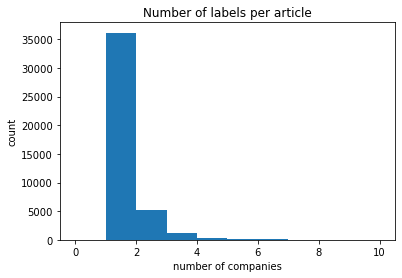

In [93]:
multiple_siren_list = list()
for document in corpus_cleaned:
    if len(document["siren"])==0:
        print ("ALERT article sans label, id:",document["id"])
    multiple_siren_list.append(len(document["siren"]))
    
print(stats.describe(multiple_siren_list))   
print ("There are",multiple_siren_list.count(1),"arcticles with ONLY ONE label out of the",len(corpus_cleaned),"articles") 

plt.hist(multiple_siren_list,range =(0,10), bins=10) #bins=20
plt.xlabel('number of companies')
plt.ylabel('count')
plt.title('Number of labels per article')

## Study of the number of articles associated to each Company

DescribeResult(nobs=23824, minmax=(1, 147), mean=2.2873992612491607, variance=21.2056910237261, skewness=11.264005502380718, kurtosis=207.75141665216637)
There are 66.65 % of companies with ONLY ONE associated article
There are 93.7 % of companies with LESS THAN 6 associated articles
There are 1501 companies with more than 6 associated articles


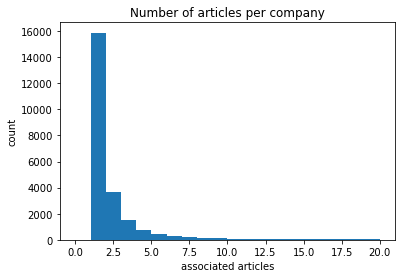

In [94]:
# We consider companies with at least one associated article for this study

values = list(dict_count.values())
plt.hist(values,range =(0,20), bins=20) #bins=20
plt.xlabel('associated articles')
plt.ylabel('count')
plt.title('Number of articles per company')

number = 6
print(stats.describe(values))
print ("There are",round(values.count(1)/len(values)*100,2), "% of companies with ONLY ONE associated article")
under_n = [1 for i in values if i < number]
print ("There are",round(len(under_n)/len(values)*100,2), "% of companies with LESS THAN",number,"associated articles")
print ("There are",len(values)-len(under_n), "companies with more than",number,"associated articles")

## Study of number of words in articles 

There are 0 articles with LESS than 20 words
There are 3919 articles with MORE than 500 words


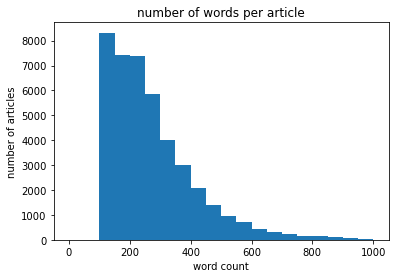

In [95]:
word_count = list()
for document in corpus_cleaned:
    word_count.append(len(document["corpus"]))
max_count = 1000
plt.hist(word_count,range =(0,max_count), bins=20) #bins=20
plt.xlabel('word count')
plt.ylabel('number of articles')
plt.title('number of words per article')
under = 20
over = 500
n_under = len([count for count in word_count if count<under])
n_over = len([count for count in word_count if count>over])
print ("There are",n_under,"articles with LESS than",under,"words")
print ("There are",n_over,"articles with MORE than",over,"words")

## Finding companies with at least N associated articles 

In [96]:
#Exemple de count pour une entreprise donnée
#print(list(dict_names.keys())[0:5])
print (dict_names['322120916'])
name_search = "APPLE FRANCE"
for siren, name in dict_names.items():  #fetch siren of company name
    if name_search in name:
        print(siren, name)
print(name_search,"a",dict_count["322120916"],"articles dans le corpus")

APPLE FRANCE
322120916 APPLE FRANCE
APPLE FRANCE a 7 articles dans le corpus


In [179]:
n_associated_articles = 6 # Number of articles a company must have to be kept in the list
siren_filtered =[key for key in dict_count if dict_count[key] >= n_associated_articles]
print ("There are",len(siren_filtered),"companies with MORE than",n_associated_articles,"associated articles out of the",len(dict_names.keys()),"initial companies")

There are 1501 companies with MORE than 6 associated articles out of the 30178 initial companies


# Creation de Train et Test set pour l'entrainement de Tf.Idf

In [98]:
from sklearn.model_selection import train_test_split
import random

In [99]:
# Remove all of the articles that dont talk about our selected companies (in siren filtered)
# Split corpus train/test
corpus = corpus_cleaned
test_size = 0.3

#Removing unwanted articles
print("Removing unwanted articles (articles that do not correspond to the company list provided)")
corpus_temp = list()
for document in corpus:
    keep = False
    for document_sirens in document["siren"]:
        for sirens in siren_filtered:
            if document_sirens == sirens:
                keep = True
    if keep:
        corpus_temp.append(document)
print ("We removed:",len(corpus)-len(corpus_temp),"articles and we have",len(corpus_temp),"articles left")
corpus = corpus_temp
 
#Splitting data
print("Splitting data") 
X_train_corpus, X_test_corpus = train_test_split(corpus, test_size=test_size, random_state=0)

print ("We have",len(X_train_corpus),"documents in the training corpus")
print ("We have",len(X_test_corpus),"documents in the testing corpus")

Removing unwanted articles (articles that do not correspond to the company list provided)
We removed: 23707 articles and we have 19697 articles left
Splitting data
We have 13787 documents in the training corpus
We have 5910 documents in the testing corpus


In [177]:
len(corpus_temp)

19697

## Removing the corpus labels that we don't want to predict

In [100]:
def clean_corpus_labels (corpus, siren_filtered):
    removed = 0
    for document in corpus:
        sirens = list()
        for siren in document["siren"]:
            if siren in siren_filtered:
                sirens.append(siren)
            else:
                removed+=1
        document["siren"]=sirens
    print ("Number of labels removed:",removed)
    return corpus

In [101]:
# siren_filtered
corpus = X_test_corpus
sirens_to_keep = siren_filtered
X_test_corpus_filtered = clean_corpus_labels(corpus, sirens_to_keep)

Number of labels removed: 1395


In [ ]:
len(siren_filtered)

In [178]:
# For Demo
print (len(corpus_temp))
# save corpus_temp
PATH = "./data/corpus/"
file = "cleaned_tokenized_corpus"
a_file = open(PATH + file + ".json", "w")
json.dump(corpus_temp, a_file)
a_file.close()
print (file,"is saved successfully")

19697
cleaned_tokenized_corpus is saved successfully


# Tf.Idf pour une liste d'entreprise sur le training data (1h20)

In [59]:
# imports
from sklearn.feature_extraction.text import TfidfVectorizer 

In [60]:
# Functions for Fetching relevant words using Tf.Idf on Company related articles

def identity_tokenizer(text):
    return text

# generate relevant words using TF-IDF (sublinear)
def generate_relevant_words_tfidf(corpus,list_siren):
    relevant_words_tfidf = {}
    for siren in tqdm(list_siren):
        plain_text_list = list()
        company_article = list()
        #binary = True
        #sublinear_tf=False
        tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, ngram_range = (1,1), lowercase=False, sublinear_tf=True)
        #tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, ngram_range = (1,1), lowercase=False, sublinear_tf=False)
        #Building "forground"
        for document in corpus:
            if siren in document["siren"]:
                company_article = company_article+document["corpus"]  # add article to company BIG article
            else:
                plain_text_list.append(document["corpus"]) # otherwise add to corpus

        plain_text_list.insert(0,company_article) # add company article to begging of corpus
        tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(plain_text_list)

        #Get the tf-idf scores for the words in the company article complication.(=forground)
        first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] # discard tf.idf scores for the other texts

        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
        df = df.sort_values(by=["tfidf"],ascending=False).head(40) # Take top 40 words

        relevant_words_tfidf[siren] = list(zip(list(df.index),list(df["tfidf"]))) # format result
    return relevant_words_tfidf

In [61]:
#Generating relevant words using tf.idf
corpus = X_train_corpus # corpus
list_siren = siren_filtered
relevant_words_tfidf = generate_relevant_words_tfidf(corpus,list_siren)
#100%|██████████| 2084/2084 [2:28:45<00:00,  4.28s/it] # tokenized tf
#100%|██████████| 2084/2084 [2:03:31<00:00,  3.56s/it] # tokenized binary
#100%|██████████| 2084/2084 [3:06:54<00:00,  5.38s/it]   # tokenized sublinear_tf
#100%|██████████| 2084/2084 [1:21:23<00:00,  2.34s/it] # nouns sublinear_tf

100%|██████████| 1584/1584 [2:05:31<00:00,  4.75s/it]    


In [3]:
# load dictionary 
PATH = "./relevant_words/francais/"
file = "rw_tfidf_sublinear_tf_100wa"
a_file = open(PATH + file + ".json", "r")
relevant_words_tfidf = json.load(a_file)
#relevant_words_tfidf = dict(relevant_words_tfidf)
# check if well loaded
print (file,"is loaded successfully") 

rw_tfidf_sublinear_tf_100wa is loaded successfully


### Study of the relevant word distribution

In [74]:
len (relevant_words_tfidf)
# Get first relevant word of each company

#####distinct word count
n_first_words = 1
first_n_rw_list = list()
for siren in relevant_words_tfidf.keys():
    for i in range (n_first_words):
        first_n_rw_list.append(relevant_words_tfidf[siren][i][0]) 
print("There are",len(set(first_n_rw_list)),"distinct first",n_first_words,"relevant words out of the",n_first_words*len(relevant_words_tfidf),"total words")
count = list()
multiple_words = list()
for word in set(first_n_rw_list):
    count.append(first_n_rw_list.count(word))
    if first_n_rw_list.count(word)>1:
        multiple_words.append([word,first_rw_list.count(word)])
#print("max rep of word ",max(count))
#print (multiple_words)

### Distinct relevant word set
first_rw_sets = list()
n_first_words = 6
count = 0
for siren in relevant_words_tfidf.keys():
    tmp_set = set()
    for i in range (n_first_words):
        tmp_set.add(relevant_words_tfidf[siren][i][0])
    first_rw_sets.append(tmp_set)
count_same_set =np.zeros(len(first_rw_sets))
for i in range (len(first_rw_sets)):
    for word_set in first_rw_sets:
        if first_rw_sets[i] == word_set:
            count_same_set[i]+=1
    if count_same_set[i] >1:
        print(first_rw_sets[i])
        count+=1
print(count)


There are 1441 distinct first 1 relevant words out of the 1501 total words
0


# Fetching Relevant Words from ES

In [44]:
# load dictionary 
PATH = "./relevant_words/francais/"
#file = "relevant_words_train"
file = "relevant_words_VF"
a_file = open(PATH + file + ".json", "r")
relevant_words_es = json.load(a_file)

# check if well loaded
print (file,"is loaded successfully") 

relevant_words_VF is loaded successfully


In [45]:
# Collect only the relevant words for the sirens that we want to consider
count = 0
for siren in siren_filtered:
    if siren in relevant_words_es.keys():#relevant_words_es
        count +=1
    else:
        print(siren)
print ("There are", count, "companies in the ES RWords out of the",len(siren_filtered), "words in the article labels")

341535094
483790069
428820146
790148001
775709702
180020026
408954360
808332670
233500016
There are 1492 companies in the ES RWords out of the 1501 words in the article labels


In [236]:
siren_only_in_corpus.count("483790069")

1

In [46]:
# Removing all the empty significant words and keeping only siren_filtered
relevant_words_es_clean = dict()
for siren in siren_filtered:
    if siren in relevant_words_es.keys():
        if len(relevant_words_es[siren])>0:
            relevant_words_es_clean[siren] = relevant_words_es[siren]
len(relevant_words_es_clean.keys())
print ("There are", len(relevant_words_es_clean.keys()), "non empty companies in ES RWords out of the",len(siren_filtered), "words in the article labels")

There are 1489 non empty companies in ES RWords out of the 1501 words in the article labels


# Building baseline model - To FIX by tokenising

In [38]:
#Labeling article if it has the company name in it
relevant_words_baseline = dict()
for siren in siren_filtered:
    if siren in dict_names.keys():
        relevant_word_list =list()
        company_name = dict_names[siren].split(" ")
        for name in company_name: 
            relevant_word_list.append([name.lower(),1])
        relevant_words_baseline[siren] = relevant_word_list
    else:
        print(siren,"doesn't have a name in the company name list")
#relevant_words_baseline

341535094 doesn't have a name in the company name list
483790069 doesn't have a name in the company name list
428820146 doesn't have a name in the company name list
790148001 doesn't have a name in the company name list
775709702 doesn't have a name in the company name list
180020026 doesn't have a name in the company name list
408954360 doesn't have a name in the company name list
808332670 doesn't have a name in the company name list
233500016 doesn't have a name in the company name list


# Text Classifier

In [23]:
# imports ADD ALL the NECESSARY imports
import operator
import string 
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
stop_words = stopwords.words('french')

In [79]:
class ArticleClassifier:

    def __init__(self,n_sig_words=3,min_score=0.5,t=250):
        # HyperParameters
        self.n_sig_words=n_sig_words
        self.min_score = min_score
        self.t = t
        self.epsilon = 0.0001
        self.rounding = 3 # Number of significant numbers
        self.related_words = {}
        self.article_label_set = list()
        # Predition attributes
        self.pred_eval = list() # Tag each prediction 1:correct, 0:wrong for each article
        self.pred_labels = list() # Siren predicted for each article
        self.article_eval = list() # Tag each label if 1:predicted, 0:not predicted for each article
        self.article_labels = list() # Siren labels for each article
        self.pred_labels_flat = list() #list all predicted sirens flattened
        self.article_labels_flat = list() # list of all siren labels flattened
        # Evaluation attributes
        self.score1 = 0       
        self.score2 = 0
        self.score3 = 0       
        self.score4 = 0         
        self.avg_n_pred = 0       
        self.avg_n_labels = 0        
        self.most_commun_label = 0
        # Company evaluation
        self.company_positive = list()
        self.company_accuracy_list = list()
        self.company_precision_list = list()
        self.company_recall_list = list()
        self.company_F1score_list = list()
        # Article evaluation
        self.alpha_eval_list = list()
        self.article_recall_list = list()
        self.article_precision_list = list()
        self.alpha = 1   # penalizes errors if >1 hides errors if <1
        self.beta = 0.25 # weight for the missed labels (False Negative)
        self.gamma = 1   # weight for the wrongly predicted (False positives)
        
    #################################################################
    # Adds scored relevant words to the model
    #Input  : relevant word dictionary
    #Output : Text removing all punctuation and lowercased
    #################################################################
    def fit(self, relevant_word_dict):
        self.related_words = relevant_word_dict
        self.article_label_set = list(relevant_word_dict.keys())
    
    
    
    #################### PREDICTION FUNCTIONS #################################################################
    
    #################################################################
    # CLEANING PLAIN TEXT (use on un tockenize, uncleaned text)
    # Input  : Plain text - String
    # Output : Text removing all punctuation and lowercased
    #################################################################
    def clean_plain_text(self,text):
        text = text.lower() # lower
        text = text.translate(str.maketrans("","", string.punctuation)) # removing punctuation
        text = re.sub(r'»|«|–|…', '', text)  # suprime guillmets 
        text = re.sub(r'è|é|ê|ë|ē|ė|ę', 'e', text)  # suprime accents sur le e
        text = re.sub(r'à|á|â|ä|æ|ã|å|ā', 'a', text)  # suprime accents sur le a
        text = re.sub(r'\s+', ' ', text) # remove everything else
        text = word_tokenize(text)
        cleaned_text = list()
        for word in text:
            if len(word)>1:
                if word not in stop_words:
                    cleaned_text.append(word)
        text = cleaned_text
        return text

    
    
    #################################################################
    # Gives a companies "related score" wrt an article (using it's significant words)
    #INPUT :plain_text- String/ word_list - list of significant words
    #OUTPUT: Score the chances the company is related to the article
    #################################################################
    def company_relevance_score(self,plain_text,sig_words_list): 
        sig_words = np.array(sig_words_list)[:,0]
        sig_words_score = np.array(sig_words_list)[:,1].astype(np.float) #CHANGED
        sig_words_score = sig_words_score/np.sum(sig_words_score) # normalizing all of the sig_words scores
        sum_exp = np.sum([np.exp(float(score)) for score in sig_words_score]) # denominator for computing the soft max
        n_words = len(plain_text)

        words_in_text = 0
        for i in range(len(sig_words_list)):
            word_soft_max = np.exp(float(sig_words_score[i]))/sum_exp
            words_in_text += word_soft_max*plain_text.count(sig_words[i])
        
        return words_in_text/n_words+self.epsilon # relevance score for the company
    
    
    
    #################################################################
    # For an Article, gives the "related scores"(likeness of being a label) for all companies
    #INPUT :plain_text- String/company related words - dict/ params
    #OUTPUT: dict of companies and their "related scores"
    #################################################################
    def text_label_scores(self,plain_text, criterion = "T"):
        label_dict = {}
        label_dict_res = {}
        for siren in self.related_words.keys():
            sig_words_list = np.array(self.related_words[siren])[:self.n_sig_words] # Build significant word list (with no scores)
            score = self.company_relevance_score(plain_text, sig_words_list)
            score = 1 - 1/(1 + self.t*score) # smooth relevant scores
            label_dict[siren]= score

        label_dict = {k: v for k, v in sorted(label_dict.items(), key=lambda item: -item[1])} # sort all companies wrt score

        for label in label_dict.keys():
            if label_dict[label]>=self.min_score:
                label_dict_res[label] = label_dict[label]
        if (criterion.lower() == 't'):
            if label_dict_res == {}:
                label_dict_res[list(label_dict.keys())[0]] = label_dict[list(label_dict.keys())[0]]

        return label_dict_res #relevance score for each company
    
    
    
    #################################################################
    # For an Article, predicts the labels (sirens)
    #INPUT : plain_text- String/company related words - dict/ params
    #OUTPUT: dict of companies and their "related scores"
    #################################################################
    def label_text(self,plain_text,criterion = "T"):
        label_dict = self.text_label_scores(plain_text,criterion)
        sirens = list(label_dict.keys())
        return sirens # No limitation of the number of labels 
    
    
    #################################################################
    # Predict le labels of a given corpus wrt. the given hyper parameters
    #INPUT : Corpus, hyper parameters
    #OUTPUT: Predicted companies for each article
    #################################################################
    def predict(self,corpus,max_n_pred = None, criterion = "T"):
        #for document in tqdm(corpus):
        for document in corpus:
            plain_text = document["corpus"]
            
            #self.pred_labels
            pred_sirens = self.label_text(plain_text, criterion)[:max_n_pred] # predict labels
            self.pred_labels.append(pred_sirens)
            #self.pred_labels_flat
            self.pred_labels_flat += pred_sirens

            #self.article_labels
            true_sirens =document["siren"]
            self.article_labels.append(true_sirens)
            #self.article_labels_flat
            self.article_labels_flat +=true_sirens

            #self.pred_eval 
            is_labeled = [0]*len(pred_sirens)
            for i in range(len(pred_sirens)):  # For each predicted company
                for label in true_sirens: # For each labeled company
                    if pred_sirens[i]==label:  # Tag if it is a good or bad predictions
                        is_labeled[i]=1
            self.pred_eval.append(is_labeled) 

            #self.article_eval
            is_predicted = [0]*len(true_sirens)
            for i in range(len(true_sirens)):  # For each label list
                for pred in pred_sirens:       # For each prediction on the articel
                    if true_sirens[i]==pred:    # Tag the labels that have been predicted
                        is_predicted[i]=1
            self.article_eval.append(is_predicted)
        return self.pred_labels
    
    #################### MODEL EVALUATION FUNCTIONS ###########################################################
    
    #################################################################
    # Generate scores for evaluating the model
    # INPUT: 
    # OUTPUT: 
    #################################################################
    def evaluate(self):
        ########## How many times (at least) one of the companies is predicted ##########
        acc1 = list()
        for preds in self.pred_eval:
            acc1.append(any(preds))
        self.score1 = round(np.sum(acc1)/len(self.pred_eval),self.rounding)

        ########## How many times ALL the labels are present in the prediction. ##########
        acc2 = list()
        for labels in self.article_eval:
            acc2.append(labels.count(1)== len (labels)) 
        self.score2 = round(np.sum(acc2)/len(self.pred_eval),self.rounding)

        ########## How many times ALL labels are predicted in the FIRST predictions. ##########
        acc3 = list()
        for i in range(len(self.pred_eval)):
            labels = self.article_eval[i]
            preds = self.pred_eval[i]
            acc3.append(preds[:len(labels)].count(1)== len(labels))
        self.score3 =  round(np.sum(acc3)/len(self.pred_eval),self.rounding)

        ########## How many predictions are wrong wrt. how many are right (TRUE, FALSE) ##########
        true_pred = 0
        pred = 0
        for preds in self.pred_eval:
            true_pred += np.sum(preds)
            pred += len(preds)
        self.score4 = round(true_pred/pred,self.rounding)

        ########## Average number of predictions vs average number of labels ##########
        len_label = list()
        len_pred = list()
        for i in range(len(self.pred_eval)):
            len_label.append(len(self.article_labels[i]))
            len_pred.append(len(self.pred_eval[i]))
        self.avg_n_pred = round(np.mean(len_pred),self.rounding)
        self.avg_n_labels = round(np.mean(len_label),self.rounding)

        ########## Most commun labels predicted ##########
        count_pred = dict()
        for siren in self.article_labels_flat:
            if siren in count_pred.keys():
                count_pred[siren] +=1
            else:
                count_pred[siren] = 1
        key_max = list(filter(lambda t: t[1]==max(count_pred.values()), count_pred.items()))[0][0] 
        self.most_commun_label = [key_max,np.max(list(count_pred.values()))]
        
        ########## Precision & RECALL ########## per siren(Company)

        for siren in self.article_label_set: # For each company compute it's TP,FP,TN,FN
            true_pos = 0.0  # Siren IS a label and is predicted
            false_pos = 0.0 # Siren is NOT a label and is predicted (false prediction)
            true_neg = 0.0  # Siren is NOT a label and is not predicted (don't care)
            false_neg = 0.0 # Siren IS a label and is NOT predicted
            positive = 0.0  # Siren is label

            # true_pos, false_neg
            for i in range(len(self.article_labels)):
                for j in range(len(self.article_labels[i])): # for every label
                    if siren==self.article_labels[i][j]: # If company in the list of labels -> Check if was predicted
                        positive +=1
                        if self.article_eval[i][j]==1:
                            true_pos +=1
                        else:
                            false_neg +=1

            # false_pos
            for i in range(len(self.pred_labels)):
                for j in range(len(self.pred_labels[i])):
                    if siren==self.pred_labels[i][j]:  # If company in the list of predictions -> Check if was a label (correct prediction)
                        if self.pred_eval[i][j]==0: #ie. Is not a label
                            false_pos += 1 

            if siren in list(set(self.article_labels_flat)): # Add to stats only if the company was part of the labels to predict
                if positive ==0: # redundancy with previous if statement
                    precision = 0
                    recall =0
                    accuracy = 0
                    F1score = 0
                else:
                    accuracy = true_pos/positive
                    precision = true_pos/(true_pos+false_pos)
                    recall = true_pos/(true_pos+false_neg)
                    F1score = 2*(precision*recall)/(precision+recall)

                self.company_positive.append(positive)
                self.company_accuracy_list.append(accuracy)
                self.company_precision_list.append(precision)
                self.company_recall_list.append(recall)
                self.company_F1score_list.append(F1score)

        ########## Precision & RECALL ########## per Article      
        #alpha_eval_list
        for i in range(len(self.article_labels)):
            alpha_eval = pow((1-((self.beta*self.article_eval[i].count(0) + self.gamma*self.pred_eval[i].count(0))/(len(set(self.pred_labels[i]+self.article_labels[i]))))),self.alpha) 
            self.alpha_eval_list.append(alpha_eval)
        #article_recall_list
        for label in self.article_eval:
            self.article_recall_list.append(label.count(1)/(len(label)+self.epsilon))
        #article_precision_list
        for pred in self.pred_eval:
             self.article_precision_list.append(pred.count(1)/(len(pred)+self.epsilon))
    
    def print_eval(self, verbose = 2):
        #verbose = 0,1
        if verbose == 0:
            print ("min_score :",self.min_score)
            print ("n_sig_words :",self.n_sig_words)
            print ("t :",self.t)
            print("Numbre of test articles :",len(self.pred_labels))
            print("AVG PRECISION per Company:",round(np.average(self.company_precision_list),self.rounding))
            print("AVG PRECISION per Article:",round(np.average(self.article_precision_list) ,self.rounding))
        
        elif verbose == 1:
            print ("min_score :",self.min_score)
            print ("n_sig_words :",self.n_sig_words)
            print ("t :",self.t)
            print("Number of test articles :",len(self.pred_labels))
            print("######################### For Each company #########################")
            print("AVG ACCURACY :",round(np.average(self.company_accuracy_list),self.rounding))
            print("AVG PRECISION:",round(np.average(self.company_precision_list),self.rounding))
            print("AVG RECALL   :",round(np.average(self.company_recall_list),self.rounding))
            print("AVG F1 score :",round(np.average(self.company_F1score_list),self.rounding))
            print()
            print("######################### For Each article #########################")
            print("AVG PRECISION:",round(np.average(self.article_precision_list) ,self.rounding))
            print("AVG RECALL   :",round(np.average(self.article_recall_list),self.rounding))
            print("AVG alpha eval:",round(np.average(self.alpha_eval_list),self.rounding))
   
        elif verbose == 2:
            print ("min_score :",self.min_score)
            print ("n_sig_words :",self.n_sig_words)
            print ("t :",self.t)
            print("Number of test articles :",len(self.pred_labels))
            print("Score 1:", self.score1,"(with at least ONE label predicted)")
            print("Score 2:", self.score2,"(with ALL labels predicted)")
            print("Score 3:", self.score3,"(with ALL labels predicted in the FIRST predictions)")
            print("Score 4:",self.score4,"(Number of correct predictions over total number of predictions overall)")
            print("Average number of predictions",self.avg_n_pred,"vs average number of labels :", self.avg_n_labels)
            print("The siren that is predicted the most is:",self.most_commun_label[0],"(",self.most_commun_label[1],"times)")
            print()
            print("######################### For Each company #########################")
            print("AVG ACCURACY :",round(np.average(self.company_accuracy_list),self.rounding),"True_pos/Pos -> average for each siren")
            print("AVG PRECISION:",round(np.average(self.company_precision_list),self.rounding),"True_pos/(True_Pos + False_Pos) -> average for each siren")
            print("AVG RECALL   :",round(np.average(self.company_recall_list),self.rounding),"True_pos/(True_Pos + False_Neg) -> average for each siren")
            print("AVG F1 score :",round(np.average(self.company_F1score_list),self.rounding),"combination of precision and recall -> average for each siren")
            print()
            print("######################### For Each article #########################")
            print("AVG PRECISION:",round(np.average(self.article_precision_list) ,self.rounding),"#correct_predictions/#predictions-> average for each article")
            print("AVG RECALL   :",round(np.average(self.article_recall_list),self.rounding),"#predicted_labels/#labels -> average for each article")
            print("AVG alpha eval:",round(np.average(self.alpha_eval_list),self.rounding),"prediction score of an article -> average for each article")
        

In [25]:
siren_test = list(relevant_words_tfidf.keys())[5]
relevant_words_tfidf[siren_test][:10]
dict_names[siren_test]

'SPIE OPERATIONS'

## Testing plain_texts

In [72]:
#index = 3
#plain_text = corpus_list[index]["corpus"]
#print (dict_names[corpus_list[index]["siren"][0]])

plain_text0 = """
La victoire de Joe Biden à la présidentielle américaine à peine proclamée par les principaux 
médias américains, les messages de félicitations des dirigeants occidentaux affluent. Sur Twitter,
une courte séquence vidéo fait le buzz entre Londres et Dublin. Ce 7 novembre, on y voit le 
candidat démocrate entouré de journalistes.
"""
plain_text1 = """
Créé en 2008 par deux anciens salariés d’une agence de publicité, Konbini est un site d’infotainement (infodivertissement),
mêlant informations et divertissement. Accessibles gratuitement, ces contenus sont financés par de la publicité apparente
(les fameuses bannières cliquables et parfaitement identifiables) et de la publicité plus discrète, appelée 
publi-rédactionnel et « native advertising ». En raison des systèmes de blocage de publicité, comme Adblocks, 
les sites ont de plus en plus recours à ces publicités discrètes. 
"""
plain_text2 = """
La Poste de Dijon-Mansard rouvre enfin ce mardi 22 décembre 2020 après plus de deux mois de travaux. 
Près d'un demi million d'euro a été investi par le groupe public pour développer un concept destiné à
séduire les jeunes de 15 à 30. Il faut dire que ce bureau est situé juste à côté de l'Université de 
Bourgogne et de ses 30 000 étudiants. 
"""
plain_text3 = """
Désignée par le département informatique de l'hôpital de Schwyz, SPIE ICS AG, filiale de SPIE Switzerland 
et prestataire de services informatiques complets, est en charge de l'acquisition, de la mise en œuvre,
de l'introduction et de l'exploitation de la nouvelle infrastructure réseau. Initiée début juillet 2020
pour une durée d’un an, l’opération est conduite dans le cadre d’un accord d’exploitation définissant 
les attentes de l’hôpital de Schwyz. Objectif : assurer une transition optimale du réseau initial vers 
le nouveau réseau et limiter les risques d’interruption de service.
"""
plain_text4 = """
La Poste de Dijon-Mansard rouvre enfin ce mardi 22 décembre 2020 après plus de deux mois de travaux. 
Près d'un demi million d'euro a été investi par le groupe public pour développer un concept destiné à
séduire les jeunes de 15 à 30. Il faut dire que ce bureau est situé juste à côté de l'Université de 
Bourgogne et de ses 30 000 étudiants. 
"""
plain_text5 = "Bourse en ligne : Information boursiere, Economie, Finance, Bourse de paris - Cerclefinance"


In [73]:
#EXAMPLE of clean_plain_text of ArticleClassifier

#index = 3
#plain_text = corpus_list[index]["corpus"]
#print (dict_names[corpus_list[index]["siren"][0]])
print(plain_text3)
# Building model
ac_model = ArticleClassifier() # Init Article Classifier 
plain_text = ac_model.clean_plain_text(plain_text3)
print()
print(plain_text)


Désignée par le département informatique de l'hôpital de Schwyz, SPIE ICS AG, filiale de SPIE Switzerland 
et prestataire de services informatiques complets, est en charge de l'acquisition, de la mise en œuvre,
de l'introduction et de l'exploitation de la nouvelle infrastructure réseau. Initiée début juillet 2020
pour une durée d’un an, l’opération est conduite dans le cadre d’un accord d’exploitation définissant 
les attentes de l’hôpital de Schwyz. Objectif : assurer une transition optimale du réseau initial vers 
le nouveau réseau et limiter les risques d’interruption de service.


['designee', 'departement', 'informatique', 'lhôpital', 'schwyz', 'spie', 'ics', 'ag', 'filiale', 'spie', 'switzerland', 'prestataire', 'services', 'informatiques', 'complets', 'charge', 'lacquisition', 'mise', 'œuvre', 'lintroduction', 'lexploitation', 'nouvelle', 'infrastructure', 'reseau', 'initiee', 'debut', 'juillet', '2020', 'duree', 'an', 'operation', 'conduite', 'cadre', 'accord', 'exploitation',

# Function to compute a "Related Scores" for a company

In [74]:
# EXAMPLE OF : company_relevance_score 
min_score = 0.7
n_sig_words = 3
t = 250
siren = siren_test
related_words = relevant_words_tfidf 
#related_words = relevant_words_es_clean #relevant_words_es

ac_model = ArticleClassifier(n_sig_words,min_score ,t) # Init Article Classifier 
ac_model.fit(related_words)    # fit related words

plain_text = ac_model.clean_plain_text(plain_text3)
print ("plain_text",plain_text)

related_words = np.array(ac_model.related_words[siren])[:ac_model.n_sig_words] # filter significant words
print (dict_names[siren])
print("n_significant_words:",ac_model.n_sig_words)
print ("related_words:\n",related_words)
score = ac_model.company_relevance_score(plain_text, related_words) 
print ("related score",score)
score = 1 - 1/(1 + ac_model.t*score) 
print ("smoothed related score",score)

plain_text ['designee', 'departement', 'informatique', 'lhôpital', 'schwyz', 'spie', 'ics', 'ag', 'filiale', 'spie', 'switzerland', 'prestataire', 'services', 'informatiques', 'complets', 'charge', 'lacquisition', 'mise', 'œuvre', 'lintroduction', 'lexploitation', 'nouvelle', 'infrastructure', 'reseau', 'initiee', 'debut', 'juillet', '2020', 'duree', 'an', 'operation', 'conduite', 'cadre', 'accord', 'exploitation', 'definissant', 'attentes', 'hôpital', 'schwyz', 'objectif', 'assurer', 'transition', 'optimale', 'reseau', 'initial', 'vers', 'nouveau', 'reseau', 'limiter', 'risques', 'interruption', 'service']
SPIE OPERATIONS
n_significant_words: 3
related_words:
 [['mso' '0.08937617474897541']
 ['spie' '0.0881785428302519']
 ['sag' '0.08497159718726967']]
related score 0.012952940922245052
smoothed related score 0.7640527376137234


# Function to compute and compare "Related Scores" for each company

### Testing text_label_scores

In [78]:
#EXAMPLE of : text_label_scores

related_words = relevant_words_tfidf
#related_words = relevant_words_es_clean #relevant_words_es
#related_words = relevant_words_baseline

n_sig_words= 3
min_score = 0.2 # nbr of sig words in text
t =250 # score smoothing facter: 0+: monte doucement vers 1, +inf: monte rapidement vers 1

ac_model = ArticleClassifier(n_sig_words,min_score ,t) # Init Article Classifier 
ac_model.fit(related_words)    # fit related words

plain_text = ac_model.clean_plain_text(plain_text3)
print("plain_text",plain_text)
print ("params:")

print ("n_sig_words:",ac_model.n_sig_words)
print ("min_score  :",ac_model.min_score)
print ("t          :",ac_model.t)

label_dict = ac_model.text_label_scores(plain_text, criterion = "T")
print("companies kept",label_dict)

for key in label_dict.keys(): # Should not trigger
    if len(key)>10:
        print (key, "error! this should not be triggered")

print ("The predicted companies are:")
for key in label_dict.keys():
    print(key, dict_names[key])
#relevant_words_tfidf['537450140']

plain_text ['designee', 'departement', 'informatique', 'lhôpital', 'schwyz', 'spie', 'ics', 'ag', 'filiale', 'spie', 'switzerland', 'prestataire', 'services', 'informatiques', 'complets', 'charge', 'lacquisition', 'mise', 'œuvre', 'lintroduction', 'lexploitation', 'nouvelle', 'infrastructure', 'reseau', 'initiee', 'debut', 'juillet', '2020', 'duree', 'an', 'operation', 'conduite', 'cadre', 'accord', 'exploitation', 'definissant', 'attentes', 'hôpital', 'schwyz', 'objectif', 'assurer', 'transition', 'optimale', 'reseau', 'initial', 'vers', 'nouveau', 'reseau', 'limiter', 'risques', 'interruption', 'service']
params:
n_sig_words: 3
min_score  : 0.2
t          : 250
companies kept {'399258755': 0.7640527376137234}
The predicted companies are:
399258755 SPIE OPERATIONS


# EVALUATING the MODEL

In [147]:
#EXAMPLE -> Evaluating of a Test corpus

related_words = relevant_words_tfidf #model related words
#related_words = relevant_words_es_clean #relevant_words_es
#related_words = relevant_words_baseline

#corpus = X_train_corpus[:1000] # pour verifier que on peut sur entrainer
#corpus = X_test_corpus[:200] # pour tester sur de nouveaux articles
corpus =X_test_corpus_filtered[:500]
#corpus = X_test_corpus
min_score = 0.9
n_sig_words = 3
t = 250
#max_n_pred = 3
max_n_pred = None
criterion = "T"

ac_model = ArticleClassifier(n_sig_words,min_score ,t) # Init Article Classifier 
ac_model.fit(related_words)    # fit related words
predictions = ac_model.predict(corpus,max_n_pred, criterion) # evaluate corpus
print ("There are",len(set(ac_model.pred_labels_flat)),"distinct labels predicted out of the",len(related_words.keys()),"total filtered labels")
print ("There are",len(set(ac_model.article_labels_flat)),"distinct labels TO predicted out of the",len(related_words.keys()),"total filtered labels")

There are 610 distinct labels predicted out of the 1501 total filtered labels
There are 428 distinct labels TO predicted out of the 1501 total filtered labels


In [148]:
ac_model.evaluate()
ac_model.print_eval(verbose = 2) # verbose = 0,1,2

min_score : 0.42694087378262624
n_sig_words : 3
t : 250
Number of test articles : 500
Score 1: 0.89 (with at least ONE label predicted)
Score 2: 0.852 (with ALL labels predicted)
Score 3: 0.73 (with ALL labels predicted in the FIRST predictions)
Score 4: 0.409 (Number of correct predictions over total number of predictions overall)
Average number of predictions 2.302 vs average number of labels : 1.102
The siren that is predicted the most is: 552100554 ( 5 times)

######################### For Each company #########################
AVG ACCURACY : 0.845 True_pos/Pos -> average for each siren
AVG PRECISION: 0.753 True_pos/(True_Pos + False_Pos) -> average for each siren
AVG RECALL   : 0.845 True_pos/(True_Pos + False_Neg) -> average for each siren
AVG F1 score : 0.773 combination of precision and recall -> average for each siren

######################### For Each article #########################
AVG PRECISION: 0.604 #correct_predictions/#predictions-> average for each article
AVG RECAL

Text(0.5, 1.0, 'recall hist (on each article)')

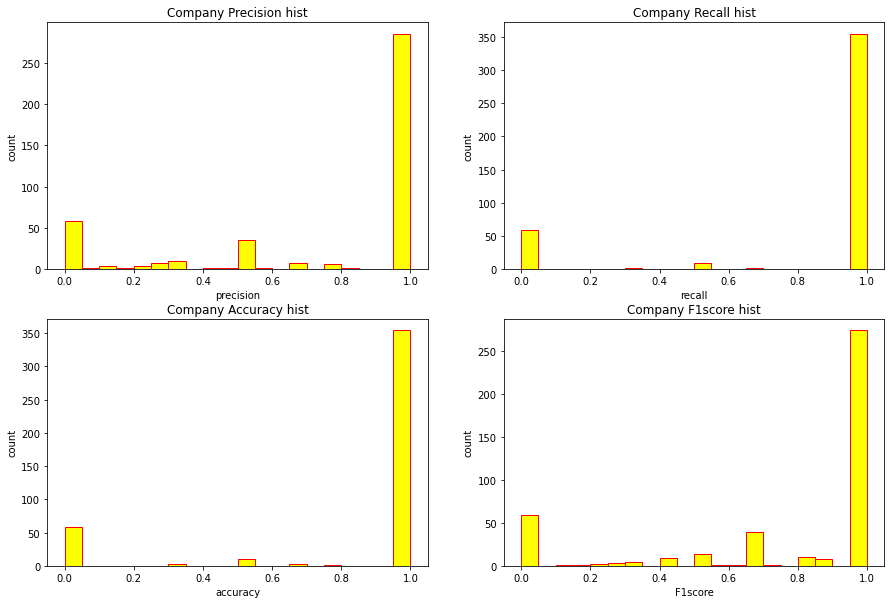

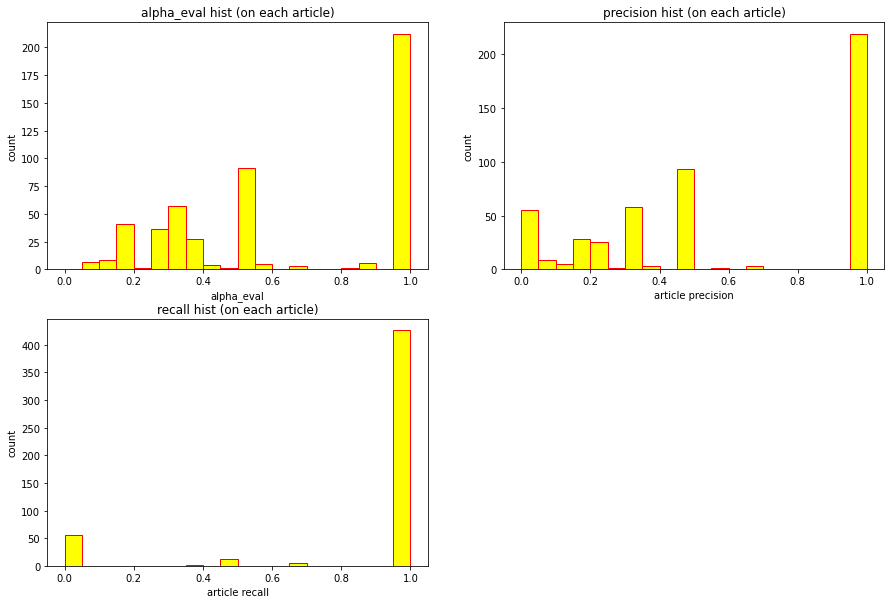

In [149]:
plt.figure(1,figsize=(15,10))
plt.subplot(2, 2, 1)
plt.hist(ac_model.company_precision_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('precision')
plt.ylabel('count')
plt.title('Company Precision hist')
plt.subplot(2, 2, 2)
plt.hist(ac_model.company_recall_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('recall')
plt.ylabel('count')
plt.title('Company Recall hist')
plt.subplot(2, 2, 3)
plt.hist(ac_model.company_accuracy_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('accuracy')
plt.ylabel('count')
plt.title('Company Accuracy hist')
plt.subplot(2, 2, 4)
plt.hist(ac_model.company_F1score_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('F1score')
plt.ylabel('count')
plt.title('Company F1score hist')
plt.figure(2,figsize=(15,10))
plt.subplot(2, 2, 1)
plt.hist(ac_model.alpha_eval_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('alpha_eval')
plt.ylabel('count')
plt.title('alpha_eval hist (on each article)')
plt.subplot(2, 2, 2)
plt.hist(ac_model.article_precision_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('article precision')
plt.ylabel('count')
plt.title('precision hist (on each article)')
plt.subplot(2, 2, 3)
plt.hist(ac_model.article_recall_list, range = (0, 1), bins = 20, color = 'yellow',edgecolor = 'red')
plt.xlabel('article recall')
plt.ylabel('count')
plt.title('recall hist (on each article)')

In [90]:
import matplotlib.pyplot as plt

In [110]:
start,end = 0,10
label_evaluation= list(zip(ac_model.article_labels[start:end],ac_model.article_eval[start:end]))
label_evaluation
#REMARQUE: On ne peut pas predire des siren qui n'ont pas plus de 5 articles associé 
#          car leur relevant words n'ont pas été calculé par le TF/IDF

[(['320992977'], [1]),
 (['403081714'], [1]),
 (['552031650'], [1]),
 (['424641066', '692030992'], [1, 1]),
 (['572067684'], [1]),
 (['350422622'], [1]),
 (['552028425'], [1]),
 (['552100554'], [1]),
 (['379402191', '489895821'], [1, 1]),
 (['394149496'], [1])]

In [111]:
start,end = 0,10
prediction_evaluation = list(zip(ac_model.pred_labels[start:end],ac_model.pred_eval[start:end]))
prediction_evaluation

[(['320992977'], [1]),
 (['403201882', '403081714'], [0, 1]),
 (['552031650'], [1]),
 (['424641066', '692030992', '414908624'], [1, 1, 0]),
 (['572067684'], [1]),
 (['350422622'], [1]),
 (['552028425'], [1]),
 (['302475041', '552100554', '542065479'], [0, 1, 0]),
 (['379402191', '489895821'], [1, 1]),
 (['808381156', '394149496', '530969781'], [0, 1, 0])]

# Hyper parameter tuning

In [112]:
# imports
import optuna
import plotly

In [173]:
def objective(trial):
    corpus = X_test_corpus[:200]
    #corpus =X_test_corpus_filtered[:200]
    min_score = trial.suggest_uniform('min_score', 0.5, 1)
    n_sig_words = trial.suggest_int('n_sig_words', 1, 5)
    
    #t = trial.suggest_int('n_sig_words', 200, 400,50)
    #max_n_pred = trial.suggest_int('n_sig_words', 1, 10,1)
    max_n_pred = None
    t = 250
    criterion = "T"
    ac_model = ArticleClassifier(n_sig_words,min_score ,t)
    ac_model.fit(related_words)  # fit related words
    predictions = ac_model.predict(corpus,max_n_pred,criterion)
    ac_model.evaluate()
    
    #return np.mean(ac_model.article_precision_list)
    return np.mean(ac_model.company_precision_list)
    #return np.mean(ac_model.alpha_eval_list)

# name them both the same!    
study_name = "study_T_company_precision"
db_name = study_name   
study = optuna.create_study(direction='maximize',study_name=study_name,storage='sqlite:///optuna_study/'+db_name, load_if_exists=True)
study.optimize(objective, n_trials=5)

print("Best hyperparameters: {}".format(study.best_params ))
print("Best hyperparameters: {}".format(study.best_value ))

[I 2021-01-11 15:47:08,534] Using an existing study with name 'study_T_company_precision' instead of creating a new one.
[I 2021-01-11 15:49:23,362] Trial 20 finished with value: 0.8460416666666667 and parameters: {'min_score': 0.957650731709458, 'n_sig_words': 3}. Best is trial 20 with value: 0.8460416666666667.


OperationalError: (raised as a result of Query-invoked autoflush; consider using a session.no_autoflush block if this flush is occurring prematurely)
(sqlite3.OperationalError) attempt to write a readonly database
[SQL: UPDATE trials SET state=?, value=?, datetime_complete=? WHERE trials.trial_id = ?]
[parameters: ('COMPLETE', 0.8460416666666667, '2021-01-11 15:51:58.106217', 22)]
(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [161]:
optuna.visualization.is_available()

True

In [165]:
# Visualisation
optuna.visualization.plot_contour(study,params=["min_score", "n_sig_words"])

In [169]:
# Check availability
optuna.visualization.matplotlib.is_available()

/opt/anaconda3/envs/P-SAT/lib/python3.7/site-packages/ipykernel_launcher.py:2: ExperimentalWarning:

is_available is experimental (supported from v2.2.0). The interface can change in the future.



True

/opt/anaconda3/envs/P-SAT/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_edf is experimental (supported from v2.2.0). The interface can change in the future.



<AxesSubplot:title={'center':'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

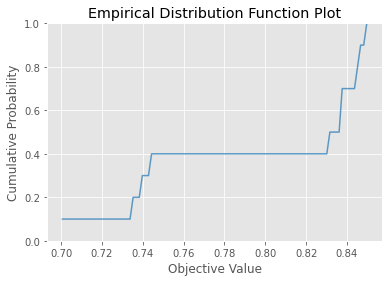

In [171]:
optuna.visualization.matplotlib.plot_edf(study)

/opt/anaconda3/envs/P-SAT/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_intermediate_values is experimental (supported from v2.2.0). The interface can change in the future.

[W 2021-01-11 15:42:18,133] You need to set up the pruning feature to utilize `plot_intermediate_values()`


<AxesSubplot:title={'center':'Intermediate Values Plot'}, xlabel='Step', ylabel='Intermediate Value'>

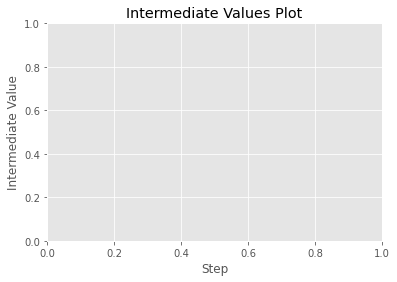

In [172]:
optuna.visualization.matplotlib.plot_intermediate_values(study)

/opt/anaconda3/envs/P-SAT/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

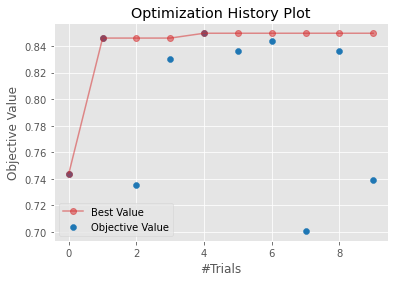

In [155]:
optuna.visualization.matplotlib.plot_optimization_history(study)

/opt/anaconda3/envs/P-SAT/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Parallel Coordinate Plot'}>

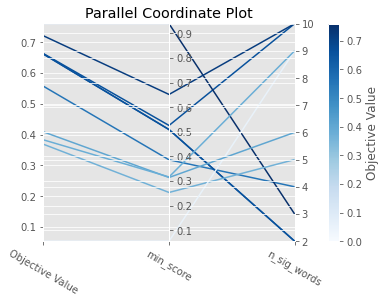

In [134]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study)

# ANNEXE

In [ ]:
#...